Skipping invalid line: 900.00, 254.12
Skipping invalid line: 901.00, 234.14
Skipping invalid line: 902.00, 213.84
Skipping invalid line: 903.00, 193.80
Skipping invalid line: 904.00, 174.54
Skipping invalid line: 905.00, 156.58
Skipping invalid line: 906.00, 140.40
Skipping invalid line: 907.00, 126.40
Skipping invalid line: 908.00, 114.90
Skipping invalid line: 909.00, 106.12
Skipping invalid line: 910.00, 100.21
Skipping invalid line: 911.00, 97.17
Skipping invalid line: 912.00, 96.94
Skipping invalid line: 913.00, 99.34
Skipping invalid line: 914.00, 104.11
Skipping invalid line: 915.00, 110.89
Skipping invalid line: 916.00, 119.30
Skipping invalid line: 917.00, 128.88
Skipping invalid line: 918.00, 139.17
Skipping invalid line: 919.00, 149.70
Skipping invalid line: 920.00, 160.02
Skipping invalid line: 921.00, 169.72
Skipping invalid line: 922.00, 178.42
Skipping invalid line: 923.00, 185.85
Skipping invalid line: 924.00, 191.78
Skipping invalid line: 925.00, 196.11
Skipping invali

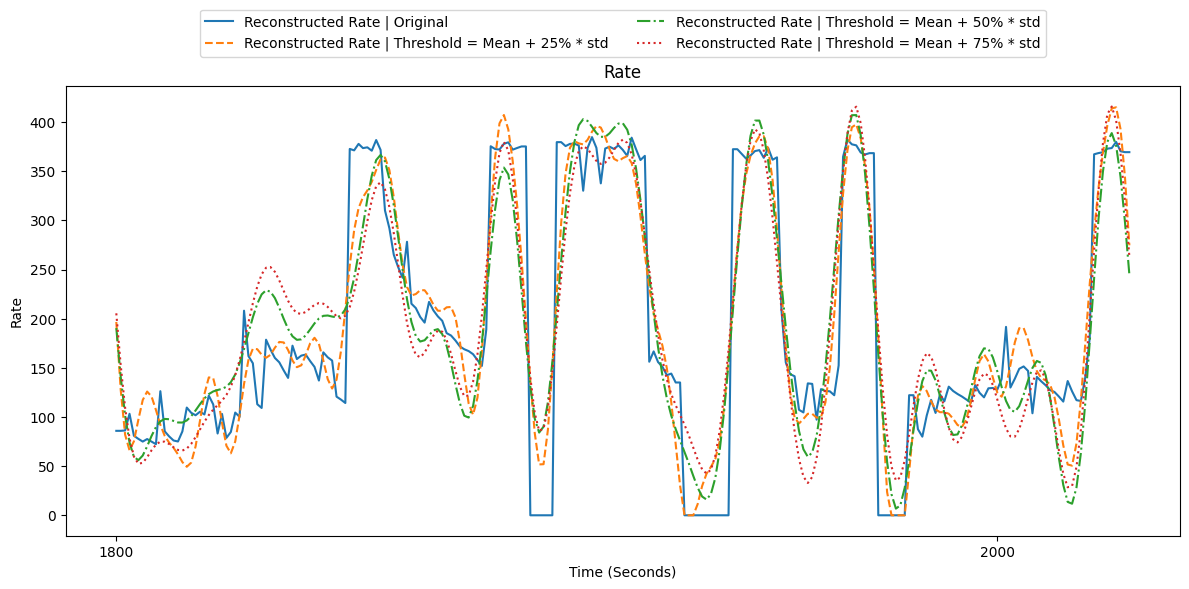

In [ ]:
import numpy as np
import scipy.fftpack as fft
import scipy.interpolate as interp
import matplotlib.pyplot as plt
from datetime import datetime

# Read and parse the log file
def read_txt_file(filename):
    times, rates = [], []
    base_time = None

    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) == 2:
                time_str, rate_str = parts
                try:
                    rate = float(rate_str.replace(" Mbps", ""))  # Remove " Mbps" before conversion
                    current_time = datetime.strptime(time_str, "%H:%M:%S")

                    if base_time is None:
                        base_time = current_time  # Set first timestamp as reference

                    time_seconds = int((current_time - base_time).total_seconds())  # Convert to seconds
                    times.append(time_seconds)
                    rates.append(rate)

                except ValueError:
                    print(f"Skipping invalid line: {line.strip()}")  # Debugging print

    if not rates:
        raise ValueError("Error: No valid numerical data found in file!")

    return np.array(times), np.array(rates)

# Adjust first and last values of each measurement section
def adjust_measurements(rates):
    nonzero_indices = np.where(rates > 0)[0]
    if len(nonzero_indices) == 0:
        return rates  # No nonzero values to adjust

    i = 0
    while i < len(nonzero_indices):
        start = nonzero_indices[i]
        while i + 1 < len(nonzero_indices) and nonzero_indices[i + 1] == nonzero_indices[i] + 1:
            i += 1
        end = nonzero_indices[i]

        if start + 1 < len(rates):
            rates[start] = rates[start + 1]

        # Adjust last value (use previous-to-last value)
        if end - 1 >= 0:
            rates[end] = rates[end - 1]

        i += 1  # Move to next measurement section

    return rates

# Interpolate missing values (zeros between measurements)
def interpolate_rates(times, rates, max_value=400):
    zero_mask = rates == 0  # Identify zero values
    nonzero_mask = ~zero_mask  # Identify nonzero values

    if np.sum(nonzero_mask) == 0:
        return rates

    interp_func = interp.Akima1DInterpolator(times[nonzero_mask], rates[nonzero_mask])
    interpolated_rates = rates.copy()

    interpolated_rates = np.clip(interpolated_rates, None, max_value)

    return interpolated_rates

def apply_fft_filtering_dynamic(rates, std_factor=1.0):
    n = len(rates)
    if n == 0:
        return rates  # Avoid FFT on empty array

    # Perform FFT
    freq_domain = fft.fft(rates)
    magnitudes = np.abs(freq_domain)  # Compute magnitude spectrum

    # Compute thresholds based on standard deviation
    mean_magnitude = np.mean(magnitudes)
    std_magnitude = np.std(magnitudes)

    threshold_25 = mean_magnitude + 0.25 * std_magnitude
    threshold_50 = mean_magnitude + 0.50 * std_magnitude
    threshold_75 = mean_magnitude + 0.75 * std_magnitude

    # Apply filtering based on different thresholds
    def filter_freq(threshold):
        filtered_freq = freq_domain.copy()
        filtered_freq[magnitudes < threshold] = 0  # Remove frequencies below threshold
        return np.real(fft.ifft(filtered_freq))

    # Generate filtered versions based on thresholds
    fft_25 = np.clip(filter_freq(threshold_25), 0, None)
    fft_50 = np.clip(filter_freq(threshold_50), 0, None)
    fft_75 = np.clip(filter_freq(threshold_75), 0, None)

    return fft_25, fft_50, fft_75, mean_magnitude, std_magnitude

def write_predictions_to_file(times, rates, filename):
    """Write predicted times and rates into a file."""
    with open(filename, 'w') as f:
        f.write("Predicted Time (seconds), Predicted Rate (Mbps)\n")
        for time, rate in zip(times, rates):
            f.write(f"{time:.2f}, {rate:.2f}\n")

filename = "log.txt"
try:
    times, rates = read_txt_file(filename)
except ValueError as e:
    print(e)

rates = adjust_measurements(rates)
interpolated_rates = interpolate_rates(times, rates)
# if len(interpolated_rates) >= 20:
#     interpolated_rates[:20] = interpolated_rates[-20:]
fft_25, fft_50, fft_75, mean_mag, std_mag = apply_fft_filtering_dynamic(interpolated_rates)
times = 1800 + times

plt.figure(figsize=(12, 6))
plt.plot(times, interpolated_rates, label="Reconstructed Rate | Original", linestyle="solid")
plt.plot(times, fft_25, label="Reconstructed Rate | Threshold = Mean + 25% * std", linestyle="dashed")
plt.plot(times, fft_50, label="Reconstructed Rate | Threshold = Mean + 50% * std", linestyle="dashdot")
plt.plot(times, fft_75, label="Reconstructed Rate | Threshold = Mean + 75% * std", linestyle="dotted")

plt.xlabel("Time (Seconds)")
plt.ylabel("Rate")
plt.xticks(np.arange(1800, max(times) + 100, step=200))  # Show ticks every 200 seconds
plt.yticks(np.arange(0, 450, step=50))

plt.title("Rate")

plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.tight_layout()
plt.show()

write_predictions_to_file(times, fft_25, "predicitions.txt")



Skipping invalid line: 900.00, 254.12
Skipping invalid line: 901.00, 234.14
Skipping invalid line: 902.00, 213.84
Skipping invalid line: 903.00, 193.80
Skipping invalid line: 904.00, 174.54
Skipping invalid line: 905.00, 156.58
Skipping invalid line: 906.00, 140.40
Skipping invalid line: 907.00, 126.40
Skipping invalid line: 908.00, 114.90
Skipping invalid line: 909.00, 106.12
Skipping invalid line: 910.00, 100.21
Skipping invalid line: 911.00, 97.17
Skipping invalid line: 912.00, 96.94
Skipping invalid line: 913.00, 99.34
Skipping invalid line: 914.00, 104.11
Skipping invalid line: 915.00, 110.89
Skipping invalid line: 916.00, 119.30
Skipping invalid line: 917.00, 128.88
Skipping invalid line: 918.00, 139.17
Skipping invalid line: 919.00, 149.70
Skipping invalid line: 920.00, 160.02
Skipping invalid line: 921.00, 169.72
Skipping invalid line: 922.00, 178.42
Skipping invalid line: 923.00, 185.85
Skipping invalid line: 924.00, 191.78
Skipping invalid line: 925.00, 196.11
Skipping invali

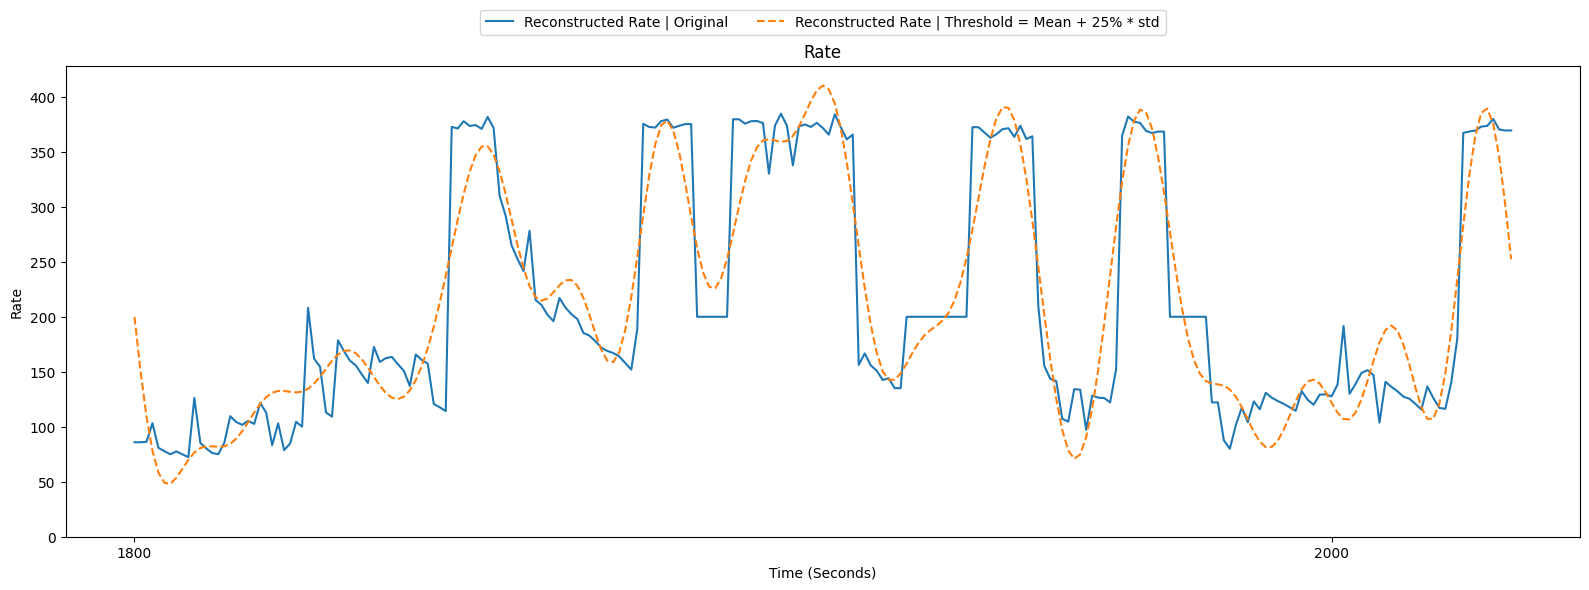

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import scipy.fftpack as fft
import matplotlib.pyplot as plt
from datetime import datetime

# Read and parse the log file
def read_txt_file(filename):
    times, rates = [], []
    base_time = None

    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) == 2:
                time_str, rate_str = parts
                try:
                    rate = float(rate_str.replace(" Mbps", ""))  # Remove " Mbps" before conversion
                    current_time = datetime.strptime(time_str, "%H:%M:%S")

                    if base_time is None:
                        base_time = current_time  # Set first timestamp as reference

                    if current_time < base_time:
                      # Midnight rollover: add 86400 seconds (one day)
                        time_seconds = int((current_time - base_time).total_seconds() + 86400)
                    else:
                        time_seconds = int((current_time - base_time).total_seconds())
                    times.append(time_seconds)
                    rates.append(rate)

                except ValueError:
                    print(f"Skipping invalid line: {line.strip()}")  # Debugging print

    if not rates:
        raise ValueError("Error: No valid numerical data found in file!")

    return np.array(times), np.array(rates)

# Adjust first and last values of each measurement section
def adjust_measurements(rates):
    nonzero_indices = np.where(rates > 0)[0]
    if len(nonzero_indices) == 0:
        return rates  # No nonzero values to adjust

    i = 0
    while i < len(nonzero_indices):
        start = nonzero_indices[i]
        while i + 1 < len(nonzero_indices) and nonzero_indices[i + 1] == nonzero_indices[i] + 1:
            i += 1
        end = nonzero_indices[i]

        if start + 1 < len(rates):
            rates[start] = rates[start + 1]

        # Adjust last value (use previous-to-last value)
        if end - 1 >= 0:
            rates[end] = rates[end - 1]

        i += 1  # Move to next measurement section

    return rates

def apply_fft_filtering_dynamic(rates, std_factor=1.0):
    n = len(rates)
    if n == 0:
        return rates  # Avoid FFT on empty array

    # Perform FFT
    freq_domain = fft.fft(rates)
    magnitudes = np.abs(freq_domain)  # Compute magnitude spectrum

    # Compute thresholds based on standard deviation
    mean_magnitude = np.mean(magnitudes)
    std_magnitude = np.std(magnitudes)

    threshold_25 = mean_magnitude + 0.25 * std_magnitude
    threshold_50 = mean_magnitude + 0.50 * std_magnitude
    threshold_75 = mean_magnitude + 0.75 * std_magnitude

    # Apply filtering based on different thresholds
    def filter_freq(threshold):
        filtered_freq = freq_domain.copy()
        filtered_freq[magnitudes < threshold] = 0  # Remove frequencies below threshold
        return np.real(fft.ifft(filtered_freq))

    # Generate filtered versions based on thresholds
    fft_25 = np.clip(filter_freq(threshold_25), 0, None)
    # fft_50 = np.clip(filter_freq(threshold_50), 0, None)
    # fft_75 = np.clip(filter_freq(threshold_75), 0, None)

    return fft_25, mean_magnitude, std_magnitude

def write_predictions_to_file(times, rates, filename):
    """Write predicted times and rates into a file."""
    with open(filename, 'w') as f:
        f.write("Predicted Time (seconds), Predicted Rate (Mbps)\n")
        for time, rate in zip(times, rates):
            f.write(f"{time:.2f}, {rate:.2f}\n")

filename = "log.txt"
try:
    times, rates = read_txt_file(filename)
    adjust_measurements(rates)
    rates = np.where(rates == 0, 200, rates)
except ValueError as e:
    print(e)

fft_25, mean_mag, std_mag = apply_fft_filtering_dynamic(rates)
times = 1800 + times

plt.figure(figsize=(16, 6))
plt.plot(times, rates, label="Reconstructed Rate | Original", linestyle="solid")
plt.plot(times, fft_25, label="Reconstructed Rate | Threshold = Mean + 25% * std", linestyle="dashed")

plt.xlabel("Time (Seconds)")
plt.ylabel("Rate")
plt.xticks(np.arange(1800, max(times) + 100, step=200))  # Show ticks every 200 seconds
plt.yticks(np.arange(0, 450, step=50))

plt.title("Rate")

plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.tight_layout()
plt.show()
plt.savefig("fft_25.png")
write_predictions_to_file(times, fft_25, "predicitions.txt")


Skipping invalid line: 900.00, 254.12
Skipping invalid line: 901.00, 234.14
Skipping invalid line: 902.00, 213.84
Skipping invalid line: 903.00, 193.80
Skipping invalid line: 904.00, 174.54
Skipping invalid line: 905.00, 156.58
Skipping invalid line: 906.00, 140.40
Skipping invalid line: 907.00, 126.40
Skipping invalid line: 908.00, 114.90
Skipping invalid line: 909.00, 106.12
Skipping invalid line: 910.00, 100.21
Skipping invalid line: 911.00, 97.17
Skipping invalid line: 912.00, 96.94
Skipping invalid line: 913.00, 99.34
Skipping invalid line: 914.00, 104.11
Skipping invalid line: 915.00, 110.89
Skipping invalid line: 916.00, 119.30
Skipping invalid line: 917.00, 128.88
Skipping invalid line: 918.00, 139.17
Skipping invalid line: 919.00, 149.70
Skipping invalid line: 920.00, 160.02
Skipping invalid line: 921.00, 169.72
Skipping invalid line: 922.00, 178.42
Skipping invalid line: 923.00, 185.85
Skipping invalid line: 924.00, 191.78
Skipping invalid line: 925.00, 196.11
Skipping invali

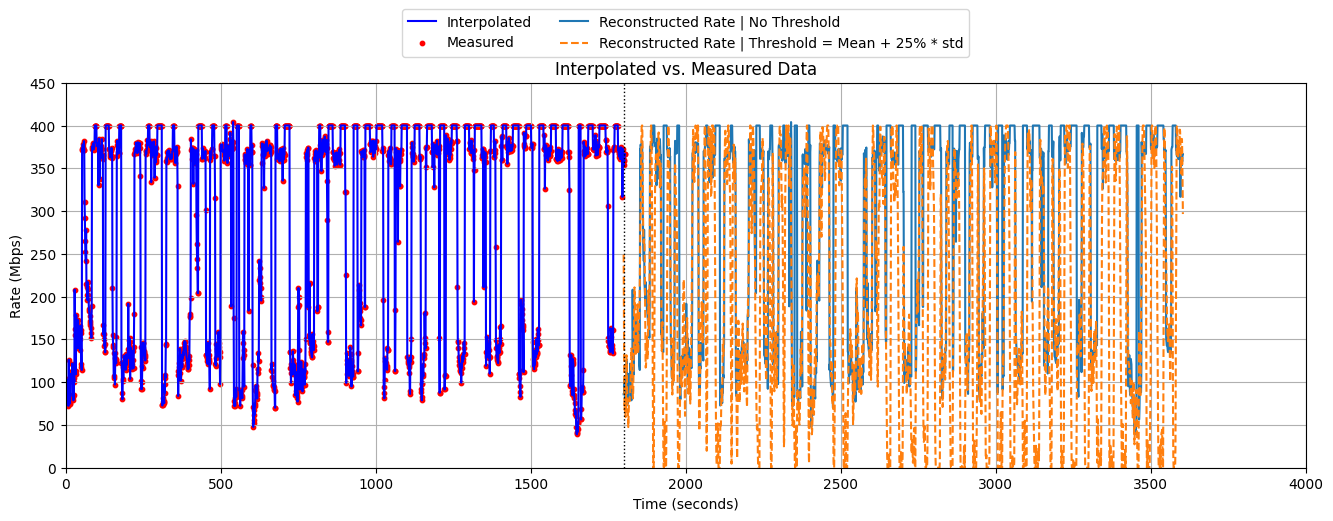

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as interp
from datetime import datetime

def read_txt_file(filename):
    times, rates = [], []
    base_time = None

    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) == 2:
                time_str, rate_str = parts
                try:
                    rate = float(rate_str.replace(" Mbps", ""))  # Remove " Mbps" before conversion
                    current_time = datetime.strptime(time_str, "%H:%M:%S")

                    if base_time is None:
                        base_time = current_time  # Set first timestamp as reference


                    if current_time < base_time:
                      # Midnight rollover: add 86400 seconds (one day)
                        time_seconds = int((current_time - base_time).total_seconds() + 86400)
                    else:
                        time_seconds = int((current_time - base_time).total_seconds())
                    times.append(time_seconds)
                    rates.append(rate)

                except ValueError:
                    print(f"Skipping invalid line: {line.strip()}")  # Debugging print

    if not rates:
        raise ValueError("Error: No valid numerical data found in file!")

    return np.array(times), np.array(rates)

def apply_fft_filtering_dynamic(rates, std_factor=1.0):
    n = len(rates)
    if n == 0:
        return rates  # Avoid FFT on empty array

    # Perform FFT
    freq_domain = fft.fft(rates)
    magnitudes = np.abs(freq_domain)  # Compute magnitude spectrum

    # Compute thresholds based on standard deviation
    mean_magnitude = np.mean(magnitudes)
    std_magnitude = np.std(magnitudes)

    threshold_25 = mean_magnitude + 0.25 * std_magnitude
    threshold_50 = mean_magnitude + 0.50 * std_magnitude
    threshold_75 = mean_magnitude + 0.75 * std_magnitude

    # Apply filtering based on different thresholds
    def filter_freq(threshold):
        filtered_freq = freq_domain.copy()
        filtered_freq[magnitudes < threshold] = 0  # Remove frequencies below threshold
        return np.real(fft.ifft(filtered_freq))

    # Generate filtered versions based on thresholds
    fft_25 = np.clip(filter_freq(threshold_25), 0, None)
    # fft_50 = np.clip(filter_freq(threshold_50), 0, None)
    # fft_75 = np.clip(filter_freq(threshold_75), 0, None)



    return fft_25, mean_magnitude, std_magnitude


# Adjust first and last values of each measurement section
def adjust_measurements(rates):
    nonzero_indices = np.where(rates > 0)[0]
    if len(nonzero_indices) == 0:
        return rates  # No nonzero values to adjust

    i = 0
    while i < len(nonzero_indices):
        start = nonzero_indices[i]
        while i + 1 < len(nonzero_indices) and nonzero_indices[i + 1] == nonzero_indices[i] + 1:
            i += 1
        end = nonzero_indices[i]

        # Adjust first value (use next value)
        if start + 1 < len(rates):
            rates[start] = rates[start + 1]

        # Adjust last value (use previous-to-last value)
        if end - 1 >= 0:
            rates[end] = rates[end - 1]

        i += 1  # Move to next measurement section

    return rates

# Load data
filename = "log.txt"
times, rates = read_txt_file(filename)
rates = adjust_measurements(rates)
# Interpolate missing data
fft_25, mean_mag, std_mag = apply_fft_filtering_dynamic(rates)
fft_25 = np.where(fft_25 > 400, 400, fft_25)
rates = np.where(rates == 0, 400, rates)

# Plot
plt.figure(figsize=(16, 5))
plt.plot(times, rates, label="Interpolated", color="blue", linestyle="-")
plt.scatter(times[rates != 0], rates[rates != 0], label="Measured", color="red", marker="o", s=10)
plt.plot(1800+times, rates, label="Reconstructed Rate | No Threshold", linestyle="solid")
plt.plot(1800+times, fft_25, label="Reconstructed Rate | Threshold = Mean + 25% * std", linestyle="dashed")
plt.xlabel("Time (seconds)")
plt.ylabel("Rate (Mbps)")
plt.title("Interpolated vs. Measured Data")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.grid()
plt.ylim(0, 400)
plt.xlim(0, 4000)
plt.yticks(np.arange(0, 500, step=50))
plt.axvline(x=1800, color='black', linestyle='dotted', linewidth=1, label="Midline (200 Mbps)")
plt.show()

Skipping invalid line: 900.00, 254.12
Skipping invalid line: 901.00, 234.14
Skipping invalid line: 902.00, 213.84
Skipping invalid line: 903.00, 193.80
Skipping invalid line: 904.00, 174.54
Skipping invalid line: 905.00, 156.58
Skipping invalid line: 906.00, 140.40
Skipping invalid line: 907.00, 126.40
Skipping invalid line: 908.00, 114.90
Skipping invalid line: 909.00, 106.12
Skipping invalid line: 910.00, 100.21
Skipping invalid line: 911.00, 97.17
Skipping invalid line: 912.00, 96.94
Skipping invalid line: 913.00, 99.34
Skipping invalid line: 914.00, 104.11
Skipping invalid line: 915.00, 110.89
Skipping invalid line: 916.00, 119.30
Skipping invalid line: 917.00, 128.88
Skipping invalid line: 918.00, 139.17
Skipping invalid line: 919.00, 149.70
Skipping invalid line: 920.00, 160.02
Skipping invalid line: 921.00, 169.72
Skipping invalid line: 922.00, 178.42
Skipping invalid line: 923.00, 185.85
Skipping invalid line: 924.00, 191.78
Skipping invalid line: 925.00, 196.11
Skipping invali

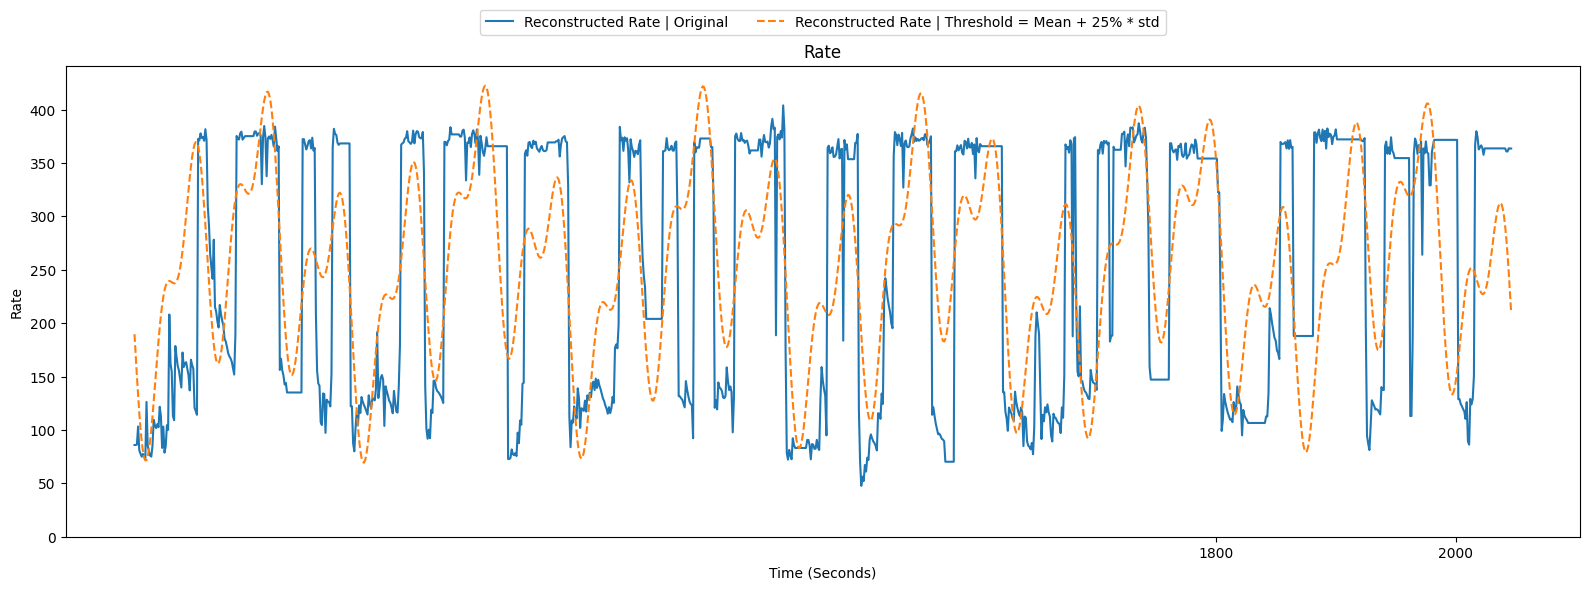

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import scipy.fftpack as fft
import matplotlib.pyplot as plt
from datetime import datetime

# Read and parse the log file
def read_txt_file(filename):
    times, rates = [], []
    base_time = None

    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) == 2:
                time_str, rate_str = parts
                try:
                    rate = float(rate_str.replace(" Mbps", ""))  # Remove " Mbps" before conversion
                    current_time = datetime.strptime(time_str, "%H:%M:%S")

                    if base_time is None:
                        base_time = current_time  # Set first timestamp as reference

                    if current_time < base_time:
                        # Midnight rollover: add 86400 seconds (one day)
                        time_seconds = int((current_time - base_time).total_seconds() + 86400)
                    else:
                        time_seconds = int((current_time - base_time).total_seconds())

                    times.append(time_seconds)
                    rates.append(rate)

                except ValueError:
                    print(f"Skipping invalid line: {line.strip()}")  # Debugging print

    if not rates:
        raise ValueError("Error: No valid numerical data found in file!")

    return np.array(times), np.array(rates)

# Adjust first and last values of each measurement section
def adjust_measurements(rates):
    nonzero_indices = np.where(rates > 0)[0]
    if len(nonzero_indices) == 0:
        return rates  # No nonzero values to adjust

    i = 0
    while i < len(nonzero_indices):
        start = nonzero_indices[i]
        while i + 1 < len(nonzero_indices) and nonzero_indices[i + 1] == nonzero_indices[i] + 1:
            i += 1
        end = nonzero_indices[i]

        if start + 1 < len(rates):
            rates[start] = rates[start + 1]

        # Adjust last value (use previous-to-last value)
        if end - 1 >= 0:
            rates[end] = rates[end - 1]

        i += 1  # Move to next measurement section

    return rates

# Replace zeros with the same average of the previous nonzero sequence
def replace_zeros_with_avg(rates):
    modified_rates = rates.copy()
    prev_sum = 0
    prev_count = 0
    avg_value = 0

    i = 0
    while i < len(modified_rates):
        if modified_rates[i] > 0:
            # Update avg using the last sequence
            if prev_count > 0:
                avg_value = prev_sum / prev_count

            # Reset sum and count for new sequence
            prev_sum = modified_rates[i]
            prev_count = 1
            i += 1
        else:
            zero_start = i  # Start of zero sequence

            # Find the length of the zero sequence
            while i < len(modified_rates) and modified_rates[i] == 0:
                i += 1

            # Replace all zeros in the sequence with avg_value
            modified_rates[zero_start:i] = avg_value

            # Reset avg tracking to avoid carrying forward adjustments
            prev_sum = 0
            prev_count = 0

    return modified_rates

# Apply FFT-based filtering dynamically
def apply_fft_filtering_dynamic(rates, std_factor=1.0):
    n = len(rates)
    if n == 0:
        return rates  # Avoid FFT on empty array

    # Perform FFT
    freq_domain = fft.fft(rates)
    magnitudes = np.abs(freq_domain)  # Compute magnitude spectrum

    # Compute thresholds based on standard deviation
    mean_magnitude = np.mean(magnitudes)
    std_magnitude = np.std(magnitudes)

    threshold_25 = np.max(magnitudes) * 0.1

    # Apply filtering based on different thresholds
    def filter_freq(threshold):
        filtered_freq = freq_domain.copy()
        filtered_freq[magnitudes < threshold] = 0  # Remove frequencies below threshold
        return np.real(fft.ifft(filtered_freq))

    # Generate filtered versions based on thresholds
    fft_25 = np.clip(filter_freq(threshold_25), 0, None)

    return fft_25, mean_magnitude, std_magnitude

def write_predictions_to_file(times, rates, filename):
    """Write predicted times and rates into a file."""
    with open(filename, 'w') as f:
        f.write("Predicted Time (seconds), Predicted Rate (Mbps)\n")
        for time, rate in zip(times, rates):
            f.write(f"{time:.2f}, {rate:.2f}\n")

# Main execution
filename = "log.txt"
try:
    times, rates = read_txt_file(filename)
    adjust_measurements(rates)
    rates = replace_zeros_with_avg(rates)  # Use new zero-replacement method
except ValueError as e:
    print(e)

fft_25, mean_mag, std_mag = apply_fft_filtering_dynamic(rates)
times = 900 + times

plt.figure(figsize=(16, 6))
plt.plot(times, rates, label="Reconstructed Rate | Original", linestyle="solid")
plt.plot(times, fft_25, label="Reconstructed Rate | Threshold = Mean + 25% * std", linestyle="dashed")
plt.xlabel("Time (Seconds)")
plt.ylabel("Rate")
plt.xticks(np.arange(1800, max(times) + 100, step=200))  # Show ticks every 200 seconds
plt.yticks(np.arange(0, 450, step=50))

plt.title("Rate")

plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.tight_layout()
plt.show()
plt.savefig("fft_25.png")
write_predictions_to_file(times, fft_25, "predictions.txt")

Skipping invalid line: 900.00, 254.12
Skipping invalid line: 901.00, 234.14
Skipping invalid line: 902.00, 213.84
Skipping invalid line: 903.00, 193.80
Skipping invalid line: 904.00, 174.54
Skipping invalid line: 905.00, 156.58
Skipping invalid line: 906.00, 140.40
Skipping invalid line: 907.00, 126.40
Skipping invalid line: 908.00, 114.90
Skipping invalid line: 909.00, 106.12
Skipping invalid line: 910.00, 100.21
Skipping invalid line: 911.00, 97.17
Skipping invalid line: 912.00, 96.94
Skipping invalid line: 913.00, 99.34
Skipping invalid line: 914.00, 104.11
Skipping invalid line: 915.00, 110.89
Skipping invalid line: 916.00, 119.30
Skipping invalid line: 917.00, 128.88
Skipping invalid line: 918.00, 139.17
Skipping invalid line: 919.00, 149.70
Skipping invalid line: 920.00, 160.02
Skipping invalid line: 921.00, 169.72
Skipping invalid line: 922.00, 178.42
Skipping invalid line: 923.00, 185.85
Skipping invalid line: 924.00, 191.78
Skipping invalid line: 925.00, 196.11
Skipping invali

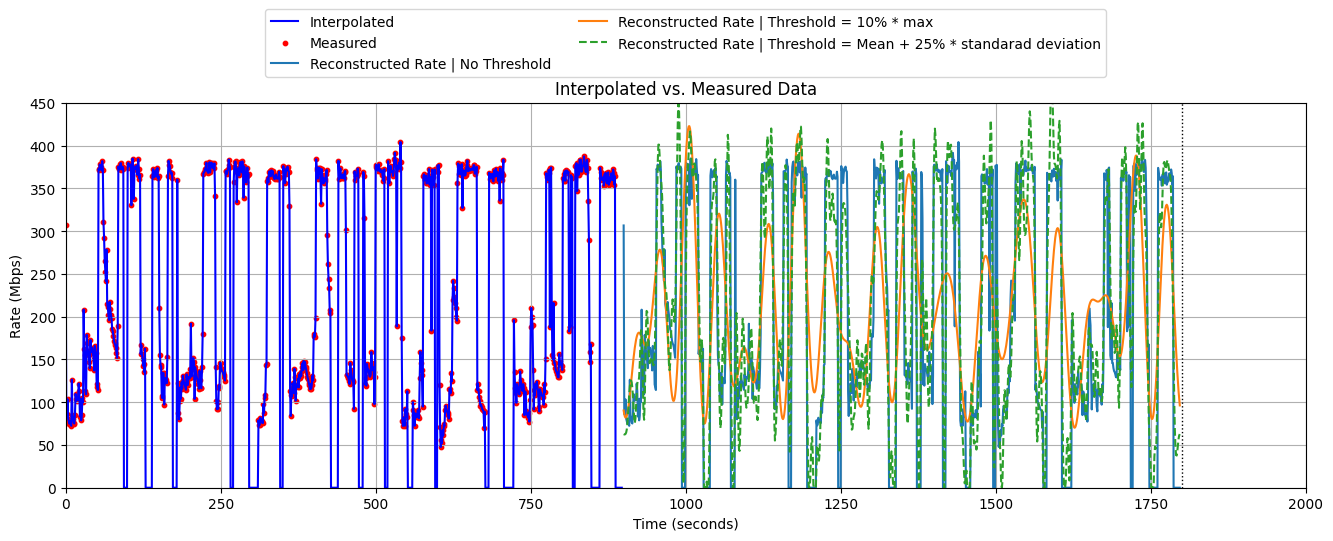

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as interp
from datetime import datetime

def read_txt_file(filename):
    times, rates = [], []
    base_time = None

    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) == 2:
                time_str, rate_str = parts
                try:
                    rate = float(rate_str.replace(" Mbps", ""))  # Remove " Mbps" before conversion
                    current_time = datetime.strptime(time_str, "%H:%M:%S")

                    if base_time is None:
                        base_time = current_time  # Set first timestamp as reference


                    if current_time < base_time:
                      # Midnight rollover: add 86400 seconds (one day)
                        time_seconds = int((current_time - base_time).total_seconds() + 86400)
                    else:
                        time_seconds = int((current_time - base_time).total_seconds())
                    times.append(time_seconds)
                    rates.append(rate)

                except ValueError:
                    print(f"Skipping invalid line: {line.strip()}")  # Debugging print

    if not rates:
        raise ValueError("Error: No valid numerical data found in file!")

    return np.array(times), np.array(rates)

def apply_fft_filtering_dynamic(rates, std_factor=1.0):
    n = len(rates)
    if n == 0:
        return rates  # Avoid FFT on empty array

    # Perform FFT
    freq_domain = fft.fft(rates)
    magnitudes = np.abs(freq_domain)  # Compute magnitude spectrum

    # Compute thresholds based on standard deviation
    mean_magnitude = np.mean(magnitudes)
    std_magnitude = np.std(magnitudes)

    threshold_25 = mean_magnitude + 0.25 * std_magnitude
    threshold_50 = mean_magnitude + 0.50 * std_magnitude
    threshold_75 = mean_magnitude + 0.75 * std_magnitude
    threshold = np.max(magnitudes) * 0.1

    # Apply filtering based on different thresholds
    def filter_freq(threshold):
        filtered_freq = freq_domain.copy()
        filtered_freq[magnitudes < threshold] = 0  # Remove frequencies below threshold
        return np.real(fft.ifft(filtered_freq))

    # Generate filtered versions based on thresholds
    fft_25 = np.clip(filter_freq(threshold_25), 0, None)
    fft_normal = np.clip(filter_freq(threshold), 0, None)
    # fft_50 = np.clip(filter_freq(threshold_50), 0, None)
    # fft_75 = np.clip(filter_freq(threshold_75), 0, None)



    return fft_25, fft_normal, mean_magnitude, std_magnitude


# Adjust first and last values of each measurement section
def adjust_measurements(rates):
    nonzero_indices = np.where(rates > 0)[0]
    if len(nonzero_indices) == 0:
        return rates  # No nonzero values to adjust

    i = 0
    while i < len(nonzero_indices):
        start = nonzero_indices[i]
        while i + 1 < len(nonzero_indices) and nonzero_indices[i + 1] == nonzero_indices[i] + 1:
            i += 1
        end = nonzero_indices[i]

        # Adjust first value (use next value)
        if start + 1 < len(rates):
            rates[start] = rates[start + 1]

        # Adjust last value (use previous-to-last value)
        if end - 1 >= 0:
            rates[end] = rates[end - 1]

        i += 1  # Move to next measurement section

    return rates

# Load data
filename = "log.txt"
times, rates = read_txt_file(filename)
# rates = adjust_measurements(rates)
# rates = replace_zeros_with_avg(rates)
# Interpolate missing data
fft_25, fft_normal, mean_mag, std_mag = apply_fft_filtering_dynamic(rates)
# fft_25 = np.where(fft_25 > 400, 400, fft_25)
# rates = np.where(rates == 0, 0, rates)

# Plot
plt.figure(figsize=(16, 5))
plt.plot(times, rates, label="Interpolated", color="blue", linestyle="-")
plt.scatter(times[rates != 0], rates[rates != 0], label="Measured", color="red", marker="o", s=10)
plt.plot(900+times, rates, label="Reconstructed Rate | No Threshold", linestyle="solid")
plt.plot(900+times, fft_normal, label="Reconstructed Rate | Threshold = 10% * max", linestyle="solid")
plt.plot(900+times, fft_25, label="Reconstructed Rate | Threshold = Mean + 25% * standarad deviation", linestyle="dashed")
plt.xlabel("Time (seconds)")
plt.ylabel("Rate (Mbps)")
plt.title("Interpolated vs. Measured Data")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.grid()
plt.ylim(0, 400)
plt.xlim(0, 2000)
plt.yticks(np.arange(0, 500, step=50))
plt.axvline(x=1800, color='black', linestyle='dotted', linewidth=1, label="Midline (200 Mbps)")
plt.show()

Skipping invalid line: 900.00, 254.12
Skipping invalid line: 901.00, 234.14
Skipping invalid line: 902.00, 213.84
Skipping invalid line: 903.00, 193.80
Skipping invalid line: 904.00, 174.54
Skipping invalid line: 905.00, 156.58
Skipping invalid line: 906.00, 140.40
Skipping invalid line: 907.00, 126.40
Skipping invalid line: 908.00, 114.90
Skipping invalid line: 909.00, 106.12
Skipping invalid line: 910.00, 100.21
Skipping invalid line: 911.00, 97.17
Skipping invalid line: 912.00, 96.94
Skipping invalid line: 913.00, 99.34
Skipping invalid line: 914.00, 104.11
Skipping invalid line: 915.00, 110.89
Skipping invalid line: 916.00, 119.30
Skipping invalid line: 917.00, 128.88
Skipping invalid line: 918.00, 139.17
Skipping invalid line: 919.00, 149.70
Skipping invalid line: 920.00, 160.02
Skipping invalid line: 921.00, 169.72
Skipping invalid line: 922.00, 178.42
Skipping invalid line: 923.00, 185.85
Skipping invalid line: 924.00, 191.78
Skipping invalid line: 925.00, 196.11
Skipping invali

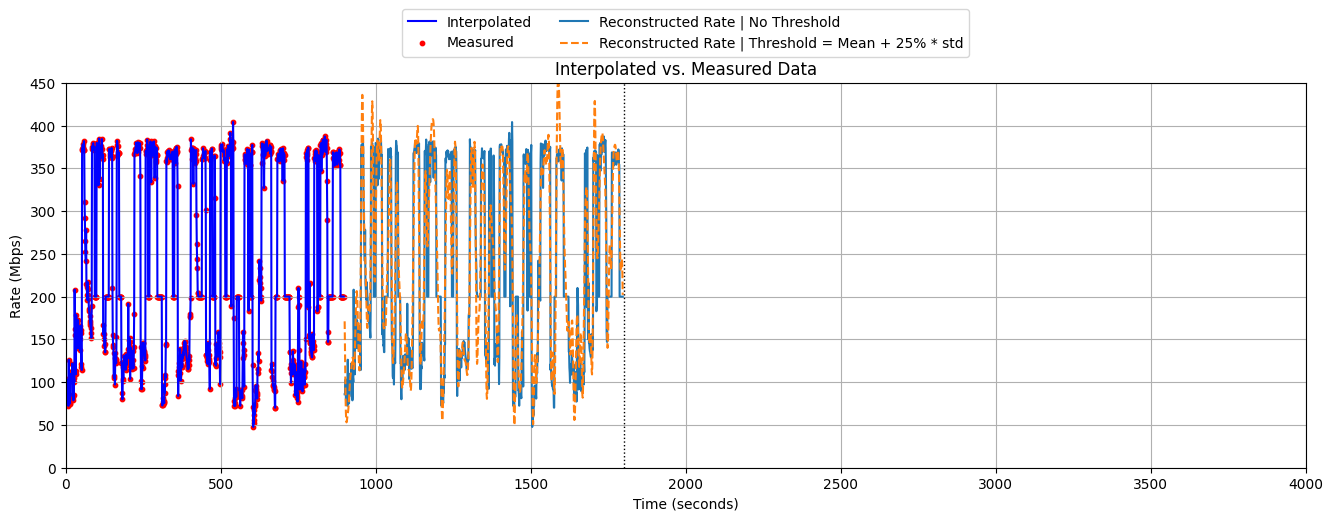

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as interp
from datetime import datetime

def read_txt_file(filename):
    times, rates = [], []
    base_time = None

    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) == 2:
                time_str, rate_str = parts
                try:
                    rate = float(rate_str.replace(" Mbps", ""))  # Remove " Mbps" before conversion
                    current_time = datetime.strptime(time_str, "%H:%M:%S")

                    if base_time is None:
                        base_time = current_time  # Set first timestamp as reference


                    if current_time < base_time:
                      # Midnight rollover: add 86400 seconds (one day)
                        time_seconds = int((current_time - base_time).total_seconds() + 86400)
                    else:
                        time_seconds = int((current_time - base_time).total_seconds())
                    times.append(time_seconds)
                    rates.append(rate)

                except ValueError:
                    print(f"Skipping invalid line: {line.strip()}")  # Debugging print

    if not rates:
        raise ValueError("Error: No valid numerical data found in file!")

    return np.array(times), np.array(rates)
# Replace zeros with the same average of the previous nonzero sequence
def replace_zeros_with_avg(rates):
    modified_rates = rates.copy()
    prev_sum = 0
    prev_count = 0
    avg_value = 0

    i = 0
    while i < len(modified_rates):
        if modified_rates[i] > 0:
            # Update avg using the last sequence
            if prev_count > 0:
                avg_value = prev_sum / prev_count

            # Reset sum and count for new sequence
            prev_sum = modified_rates[i]
            prev_count = 1
            i += 1
        else:
            zero_start = i  # Start of zero sequence

            # Find the length of the zero sequence
            while i < len(modified_rates) and modified_rates[i] == 0:
                i += 1

            # Replace all zeros in the sequence with avg_value
            modified_rates[zero_start:i] = avg_value

            # Reset avg tracking to avoid carrying forward adjustments
            prev_sum = 0
            prev_count = 0

    return modified_rates

# Apply FFT-based filtering dynamically
def apply_fft_filtering_dynamic(rates, std_factor=1.0):
    n = len(rates)
    if n == 0:
        return rates  # Avoid FFT on empty array

    # Perform FFT
    freq_domain = fft.fft(rates)
    magnitudes = np.abs(freq_domain)  # Compute magnitude spectrum

    # Compute thresholds based on standard deviation
    mean_magnitude = np.mean(magnitudes)
    std_magnitude = np.std(magnitudes)

    threshold_25 = mean_magnitude + 0.25 * std_magnitude

    # Apply filtering based on different thresholds
    def filter_freq(threshold):
        filtered_freq = freq_domain.copy()
        filtered_freq[magnitudes < threshold] = 0  # Remove frequencies below threshold
        return np.real(fft.ifft(filtered_freq))

    # Generate filtered versions based on thresholds
    fft_25 = np.clip(filter_freq(threshold_25), 0, None)

    return fft_25, mean_magnitude, std_magnitude

# Load data
filename = "log.txt"
times, rates = read_txt_file(filename)
rates = adjust_measurements(rates)
rates = np.where(rates == 0, 200, rates)
# Interpolate missing data
fft_25, mean_mag, std_mag = apply_fft_filtering_dynamic(rates)
# fft_25 = np.where(fft_25 > 400, 400, fft_25)

# Plot
plt.figure(figsize=(16, 5))
plt.plot(times, rates, label="Interpolated", color="blue", linestyle="-")
plt.scatter(times[rates != 0], rates[rates != 0], label="Measured", color="red", marker="o", s=10)
plt.plot(900+times, rates, label="Reconstructed Rate | No Threshold", linestyle="solid")
plt.plot(900+times, fft_25, label="Reconstructed Rate | Threshold = Mean + 25% * std", linestyle="dashed")
plt.xlabel("Time (seconds)")
plt.ylabel("Rate (Mbps)")
plt.title("Interpolated vs. Measured Data")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.grid()
plt.ylim(0, 400)
plt.xlim(0, 4000)
plt.yticks(np.arange(0, 500, step=50))
plt.axvline(x=1800, color='black', linestyle='dotted', linewidth=1, label="Midline (200 Mbps)")
plt.show()

3609 3609
898 898


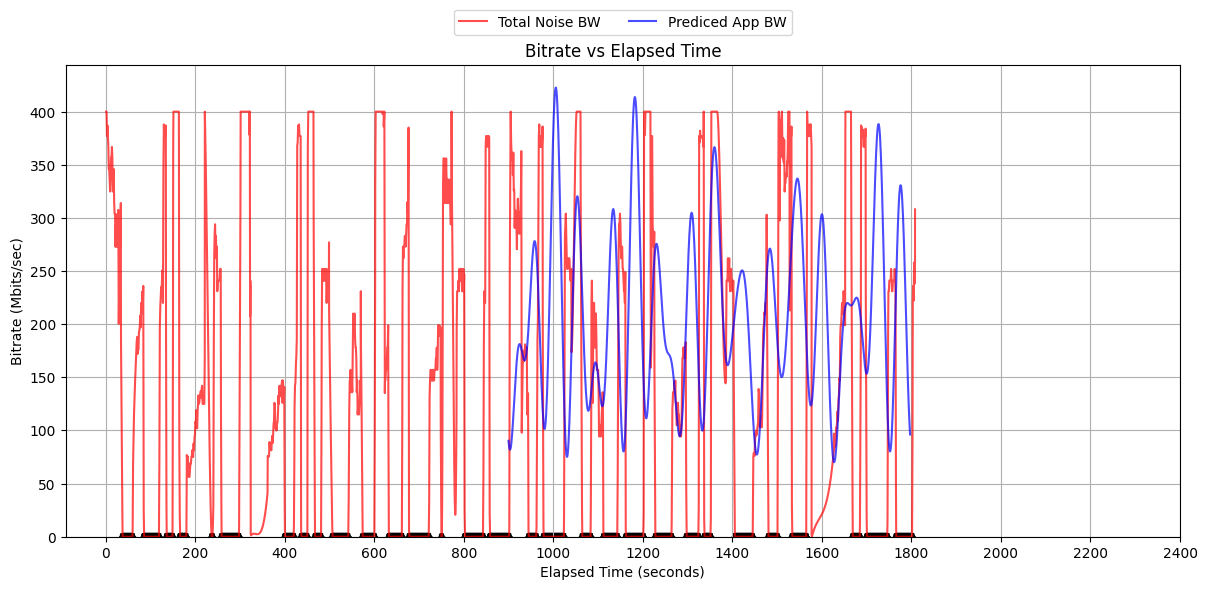

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import Akima1DInterpolator


def parse_log(file_path):
    """
    Parse a log file with structure 'seconds:bandwidth' and extract elapsed time and bitrates.
    """
    intervals = []
    bitrates = []
    elapsed_time = 0.0

    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(":")
            if len(parts) == 2:
                duration = float(parts[0])
                bitrate = float(parts[1])
                elapsed_time += duration
                intervals.append(elapsed_time)
                bitrates.append(bitrate)

    return intervals, bitrates

def average_over_intervals(intervals, bitrates, interval_size=1):
    """
    Averages the bitrate over non-overlapping intervals of 'interval_size' seconds.
    """
    averaged_intervals = []
    averaged_bitrates = []

    if len(intervals) == 0:
        return averaged_intervals, averaged_bitrates

    start_time = 0
    current_bitrates = []

    for i in range(len(intervals)):
        if intervals[i] < start_time + interval_size:
            current_bitrates.append(bitrates[i])
        else:
            if current_bitrates:
                averaged_intervals.append(start_time + interval_size / 2)
                averaged_bitrates.append(np.mean(current_bitrates))
            start_time += interval_size
            current_bitrates = [bitrates[i]]

    if current_bitrates:
        averaged_intervals.append(start_time + interval_size / 2)
        averaged_bitrates.append(np.mean(current_bitrates))

    return averaged_intervals, averaged_bitrates

def combine_bitrates(data_list):
    """
    Combine bitrates from multiple sources by summing them at each time interval.
    Handles different interval lengths using interpolation.
    Caps all bitrates at a maximum value of 400.
    """
    # Create a unified time axis covering all provided intervals
    combined_intervals = sorted(set(np.concatenate([intervals for intervals, _ in data_list])))

    # Initialize combined bitrate storage
    combined_bitrates = np.zeros(len(combined_intervals))

    # Interpolate and sum bitrates for each dataset
    for intervals, bitrates in data_list:
        interpolated_bitrates = np.interp(combined_intervals, intervals, bitrates, left=0, right=0)
        combined_bitrates += interpolated_bitrates

    # Cap values at 400
    combined_bitrates = np.minimum(combined_bitrates, 400)

    return combined_intervals, combined_bitrates

def interpolate_rates(times, rates, min_value=0, max_value=400):
    times = np.array(times, dtype=float)  # Ensure array format
    rates = np.array(rates, dtype=float)

    zero_mask = rates == 0
    nonzero_mask = rates > 0  # Boolean mask for valid values

    if np.sum(nonzero_mask) == 0:
        return rates  # No nonzero values to interpolate

    first_nonzero = np.where(nonzero_mask)[0][0]
    last_nonzero = np.where(nonzero_mask)[0][-1]

    # Ensure interpolation function is applied
    interp_func = Akima1DInterpolator(times[nonzero_mask], rates[nonzero_mask])

    # Apply interpolation only inside the valid range
    interpolated_rates = rates.copy()
    interpolated_rates[zero_mask] = interp_func(times[zero_mask])

    # Fill before first nonzero with the first nonzero value
    interpolated_rates[times < times[first_nonzero]] = rates[first_nonzero]
    # Fill after last nonzero with the last nonzero value
    interpolated_rates[times > times[last_nonzero]] = rates[last_nonzero]

    # Clip values to the allowed range
    interpolated_rates = np.clip(interpolated_rates, min_value, max_value)

    return interpolated_rates

def plot_averaged_data(data_list, labels, colors):
    """
    Plot averaged bitrate vs elapsed time with different markers.
    """
    plt.figure(figsize=(12, 6))
    markers = ['', '', '^', 's', 'p', 'x', '*', 'h', 'D', '+']
    for i, (intervals, bitrates) in enumerate(data_list):
        print(len(intervals), len(bitrates))
        plt.plot(intervals, bitrates, label=labels[i], markersize=6, linestyle='-', alpha=0.7, color=colors[i])
        # Plot a dotted line for zero measurements
        zero_mask = np.array(bitrates) == 0
        plt.scatter(np.array(intervals)[zero_mask], np.array(bitrates)[zero_mask], linestyle='dashed', marker='o', color='black', alpha=1, s=20)
    # plt.scatter([], [], linestyle='dashed', marker='o', color='black', alpha=1, label="No Noise")
    # plt.scatter(times[rates != 0], rates[rates != 0], color="green", marker="o", s=20, label="Measured App Bw")
    plt.title("Bitrate vs Elapsed Time")
    plt.xlabel("Elapsed Time (seconds)")
    plt.ylabel("Bitrate (Mbits/sec)")
    plt.legend()
    plt.grid(True)
    plt.ylim(0)
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), ncol=2)
    plt.tight_layout()
    plt.xticks(np.arange(0, 2500, step=200))
    plt.show()

if __name__ == "__main__":
    log_files = ["s1.1.txt", "s1.2.txt", "s1.3.txt"]
    labels = []
    data_list = [parse_log(file) for file in log_files]
    combined_noise_intervals, combined_noise_rate = combine_bitrates(data_list)
    interpolated_noise_bw = interpolate_rates(combined_noise_intervals, combined_noise_rate)
    data_list = []
    colors = [ "red", 'blue', 'grey']
    data_list.append((combined_noise_intervals, interpolated_noise_bw))
    labels.append("Total Noise BW")

    # data_list.append((times, rates))
    # labels.append("App BW")
    data_list.append((900+times, fft_normal))
    labels.append("Prediced App BW")
    plot_averaged_data(data_list, labels, colors)
